In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib ipympl

In [3]:
from constellation import Constellation, Const
import numpy as np
import matplotlib.pyplot as plt

In [4]:
constellation = Constellation.createFromJson('../../constellationsTest.json', 'StarLink')

Загружена группировка StarLink


In [5]:
epochs = list(range(1002))

In [6]:
stateEci = constellation.propagateJ2(epochs)

In [7]:
np.shape(stateEci)

(2000, 3, 1002)

In [8]:
for ax in (0, 1, 2):
    print(f'ax / min / max = {ax} / {np.min(stateEci[:, ax, :])} / {np.max(stateEci[:, ax, :])}')

for ax in (0, 1, 2):
    print(f'ax / min / max = {ax} / {np.min(np.abs(stateEci[:, ax, :]))} / {np.max(np.abs(stateEci[:, ax, :]))}')

ax / min / max = 0 / -6878135.0 / 6878135.0
ax / min / max = 1 / -6878134.928942243 / 6878134.928942243
ax / min / max = 2 / -7071124.453339452 / 7071124.453339452
ax / min / max = 0 / 9.280903072166557e-10 / 6878135.0
ax / min / max = 1 / 0.0 / 6878134.928942243
ax / min / max = 2 / 0.0 / 7071124.453339452


In [9]:
stateEci[:, :, 0].shape

(2000, 3)

In [10]:
stateEci[0, :, 0:10].shape

(3, 10)

#### Some visualizations of what is going on

In [11]:
def plotSphere(ax, r, **kwargs):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, **kwargs)

    return ax

def plotEarth(ax, **kwargs):
    nx, ny, nz = 0, 0, Const.earthRadius
    sx, sy, sz = 0, 0, -Const.earthRadius
    
    ax.scatter([nx], [ny], [nz], color='blue', s=2)
    ax.text(nx, ny, nz, 'N', color='blue')
    
    ax.scatter([sx], [sy], [sz], color='red', s=2)
    ax.text(sx, sy, sz, 'S', color='red')
    
    return plotSphere(ax, Const.earthRadius, alpha=1, color='gray')

def createPrettyFigure(fignum):
    ax = plt.figure(figsize=(10, 10), num=fignum).add_subplot(projection='3d')
    return ax

def prettifyAxes(ax):
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    return ax

In [12]:
def plotPositionsAtEpoch(ax, stateEci, epochIdx):
    ax.scatter(
        stateEci[:, 0, epochIdx],
        stateEci[:, 1, epochIdx],
        stateEci[:, 2, epochIdx],
        s=1,
        label=f'positions of satellites at epoch={epochIdx}',
    )
    return ax

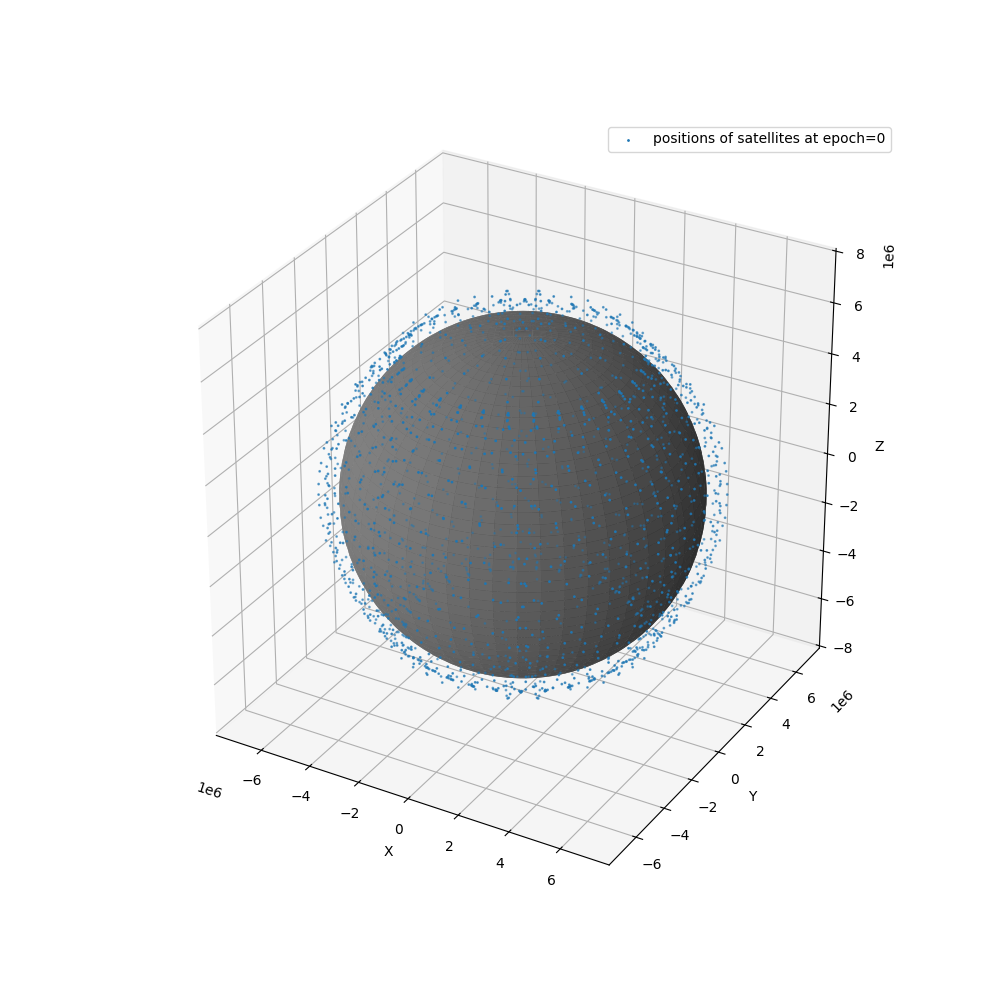

In [13]:
epochIdx = 0
ax = createPrettyFigure(f'satellites-epoch={epochIdx}')
plotEarth(ax)
plotPositionsAtEpoch(ax, stateEci, epochIdx)
prettifyAxes(ax)
plt.legend()
plt.show()

In [14]:
def plotTrajectories(ax, stateEci, satellites):
    for satIdx in satellites:
        ax.plot(
            stateEci[satIdx, 0, :],
            stateEci[satIdx, 1, :],
            stateEci[satIdx, 2, :],
        )
    return ax

/var/folders/8k/q9sb3zk15lsbmnt5dtcxhnxh0000gn/T/ipykernel_91553/3140330315.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


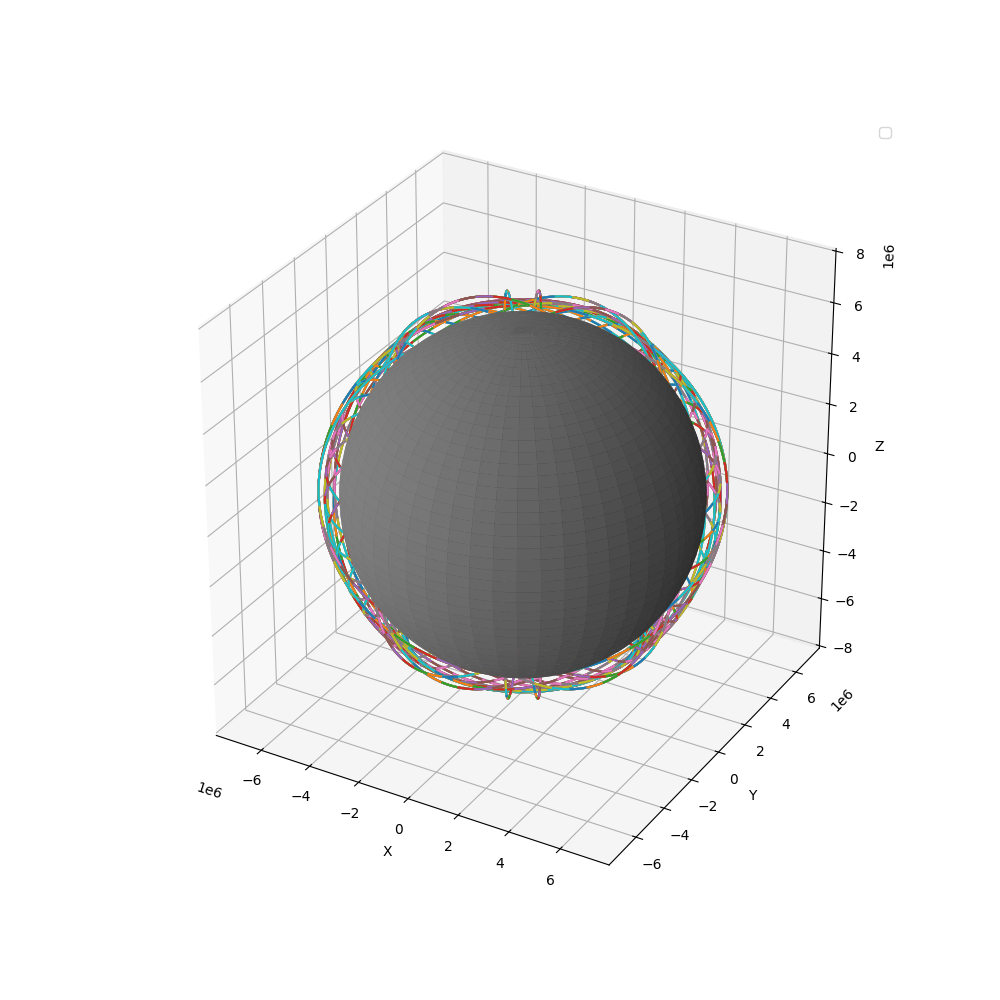

In [15]:
ax = createPrettyFigure('trajectories')
plotEarth(ax)
plotTrajectories(ax, stateEci, range(0, stateEci.shape[0]))
prettifyAxes(ax)
plt.show()

### Voronoi

#### Projection on Earth

In [16]:
def projectOnSphere(P, r):
    scale = r / np.linalg.norm(P, axis=1)
    Q = P * scale[:, np.newaxis]
    return Q

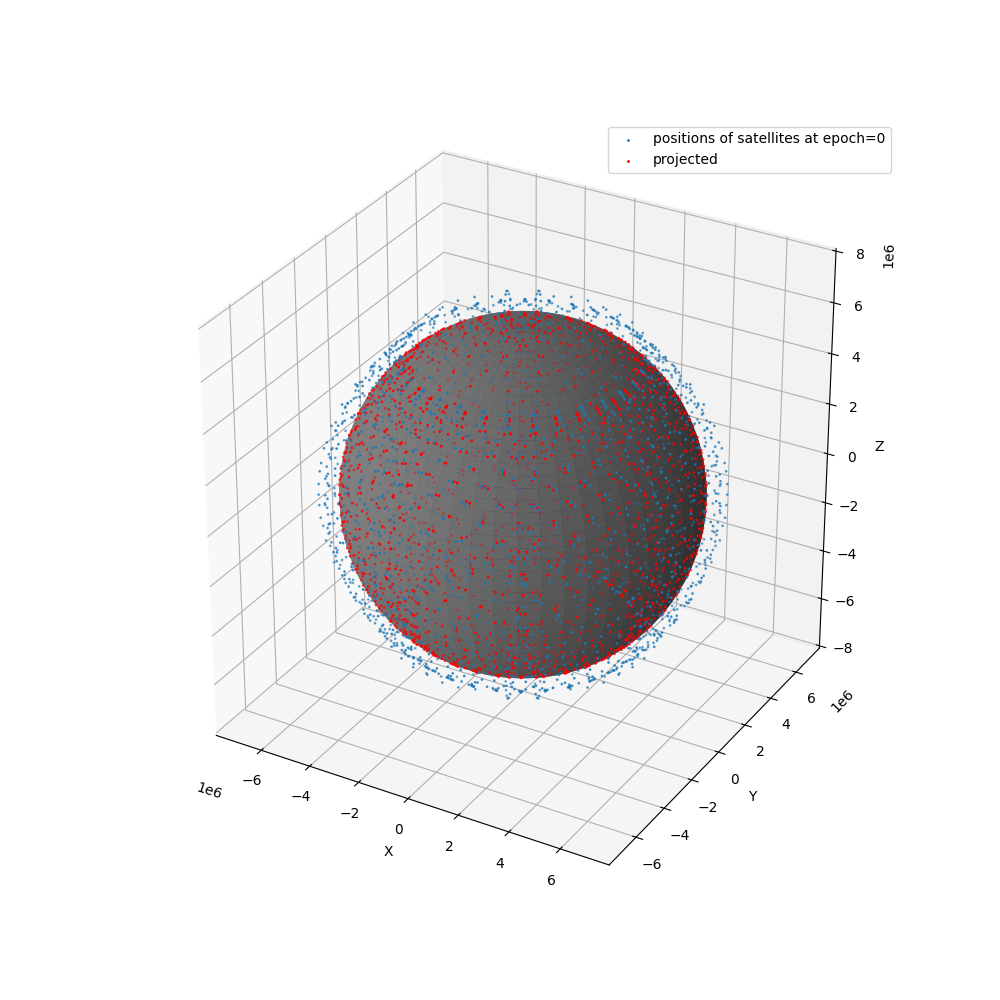

In [17]:
epochIdx = 0

P = projectOnSphere(stateEci[:, :, epochIdx], Const.earthRadius)

ax = createPrettyFigure('projection-on-earth')
ax = plotEarth(ax)
ax = plotPositionsAtEpoch(ax, stateEci, epochIdx)

# Projected
ax.scatter(P[:, 0], P[:, 1], P[:, 2], s=1, color='red', label='projected')

prettifyAxes(ax)
plt.show()

#### Spherical Voronoi of projected positions

In [18]:
import scipy as scp
import matplotlib.colors
import mpl_toolkits

In [19]:
epochIdx = 0

r = Const.earthRadius
origin = np.array([0, 0, 0])
P = projectOnSphere(stateEci[:, :, epochIdx], r)
sv = scp.spatial.SphericalVoronoi(P, r, origin)
sv.sort_vertices_of_regions()

In [20]:
V = sv.vertices

In [21]:
len(sv.regions), P.shape

(2000, (2000, 3))

In [22]:
max(map(lambda x: max(x), sv.regions)), min(map(lambda x: min(x), sv.regions))

(np.int64(3995), np.int64(0))

In [23]:
P[0], V[sv.regions[0]]

(array([6378135.,       0.,       0.]),
 array([[6364868.70708233,  166512.5759488 ,  375933.48065846],
        [6357405.14753193,  498295.58243997,  125329.09031933],
        [6364868.70708233, -166512.57594879, -375933.48065846],
        [6357405.14753194, -498295.58243996, -125329.09031933]]))

In [24]:
list( sv.vertices[[0, 1, 2]] )

[array([ 6134468.90263409,   422295.95449715, -1694273.73457056]),
 array([-1995232.61808209, -5828772.23892345, -1650777.7151154 ]),
 array([ 1445640.62525824, -4523331.82448476, -4257957.07663092])]

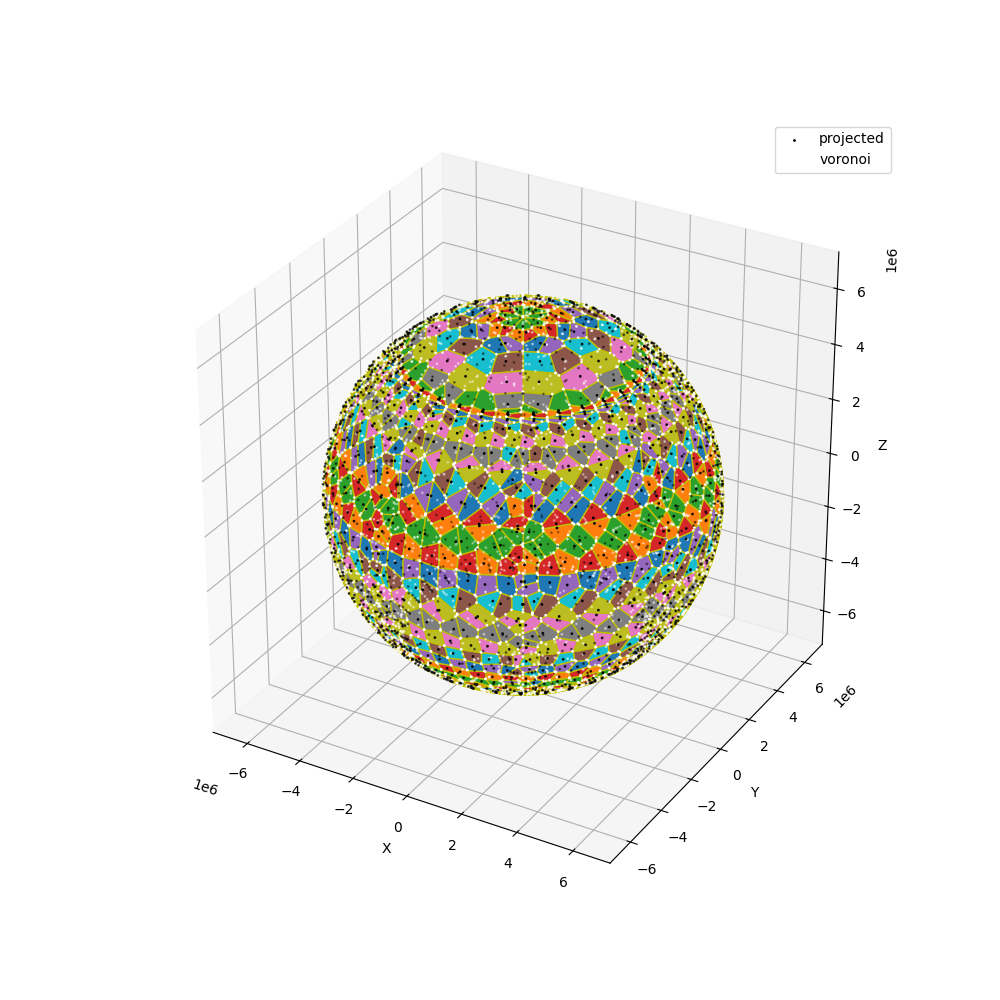

In [25]:
ax = createPrettyFigure('voronoi')

Pview = P # P[P[:, 1] < -2e6]
Vview = V # V[V[:, 1] < -2e6]

# plotEarth(ax)

ts = np.linspace(0, 1, 10)
regionColors = list(matplotlib.colors.TABLEAU_COLORS.keys())
for (regionIdx, region) in enumerate(sv.regions):
    n = len(region)

    ax.add_collection(
        mpl_toolkits.mplot3d.art3d.Poly3DCollection(
            [sv.vertices[region]],
            facecolors=regionColors[regionIdx % len(regionColors)],
            edgecolors='y',
            alpha=1.0,
        ),
    )

ax.scatter(Pview[:, 0], Pview[:, 1], Pview[:, 2], s=1, color='k', label='projected')
ax.scatter(Vview[:, 0], Vview[:, 1], Vview[:, 2], s=1, color='w', label='voronoi')
prettifyAxes(ax)
plt.show()

#### Construct graph of neighbor satellites

In [26]:
import networkx as nx
import gcol

In [27]:
class SatelliteShadowsGraph(nx.Graph):
    def __init__(self, voronoi: scp.spatial.SphericalVoronoi, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._voronoi = voronoi

    @property
    def voronoi(self):
        return self._voronoi

    @property
    def satellitePositions(self):
        return self._voronoi.points
        
    @classmethod
    def createFromCosmosPositions(cls, positionsAtEpoch, earthRadius = Const.earthRadius):
        P = projectOnSphere(positionsAtEpoch, earthRadius)
        origin = np.array([0, 0, 0])
        sv = scp.spatial.SphericalVoronoi(P, earthRadius, origin)
        sv.sort_vertices_of_regions()
        edges = __class__.findNeighborsAsEdges(sv)
        return cls(sv, edges)

    @staticmethod
    def findNeighborsAsEdges(sv):
        # Two satellites are neighbors, when they share a pair of Voronoi points
    
        edges = []
        for i1 in range(len(sv.points)):
            iSatVoronoi = sv.regions[i1]
            targetNeighborsCount = len(iSatVoronoi)
            count = 0
            
            for i2 in range(i1 + 1, len(sv.points)):
                common = set(sv.regions[i1]).intersection(sv.regions[i2]) # TODO. Can be faster?
                assert len(common) <= 2
                assert len(common) != 1
    
                if len(common) == 0:
                    continue
    
                # i1 and i2 are neighbors!
                edges.append([i1, i2])
                count += 1
                # All neighbors of i1 point are found
                if count == targetNeighborsCount:
                    break
    
        return edges

In [42]:
import abc

class NodeKColorer(abc.ABC):
    @abc.abstractmethod
    def color(self, graph, k) -> dict:
        pass

class GcolKNodeColorer(NodeKColorer):
    def color(self, graph, k):
        coloring = gcol.node_k_coloring(G, k)
        return coloring

In [43]:
class SatelliteFrequenceIdxMap(dict):
    @property
    def pool(self):
        # TODO. Should be memoized.
        return set(self.values())
    
    @classmethod
    def tryCreate(cls, G: SatelliteShadowsGraph, frequencePoolSize: int, colorer: NodeKColorer = GcolKNodeColorer()):
        # TODO. Creator algorithm/lib can be passed as argument -> Test different algos.
        coloring = colorer.color(G, frequencePoolSize)
        return cls(coloring)

class SatelliteFrequenceMap(dict):
    def __init__(self, indexMap: SatelliteFrequenceMap, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._indexMap = indexMap
        
    @property
    def pool(self):
        # TODO. Should be memoized.
        return set(self.values())

    @property
    def indexMap(self):
        return self._indexMap
    
    @classmethod
    def createFromFrequencyList(cls, idxMap: SatelliteFrequenceIdxMap, frequencyList: list):
        assert len(idxMap.pool) == len(frequencyList)
        trans = dict(enumerate(frequencyList))
        target = { k: trans[idxMap[k]] for k in idxMap.keys() }
        return cls(idxMap, target)

In [46]:
epochIdx = 101
frequencePool = [11, 12, 13, 14, 15, 16]
G = SatelliteShadowsGraph.createFromCosmosPositions(stateEci[:, :, epochIdx])
freqMap = SatelliteFrequenceMap.createFromFrequencyList(
    SatelliteFrequenceIdxMap.tryCreate(G, len(frequencePool)),
    frequencePool
)

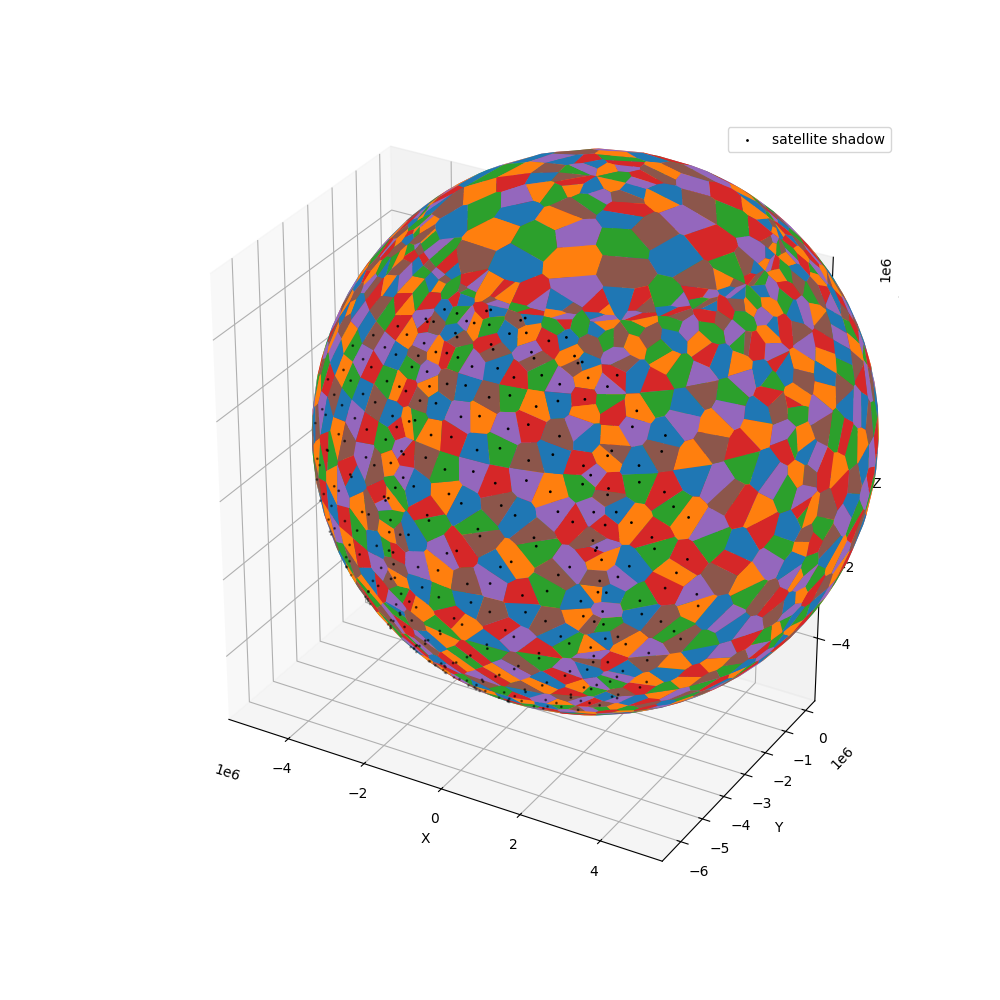

In [45]:
ax = createPrettyFigure('voronoi-neighbors')

# plotEarth(ax)
sv = G.voronoi
coloring = freqMap.indexMap
graphChromaticNumber = len(set(coloring.values()))

assert len(matplotlib.colors.TABLEAU_COLORS.keys()) >= graphChromaticNumber
regionColors = list(matplotlib.colors.TABLEAU_COLORS.keys())[0:graphChromaticNumber]

for (regionIdx, region) in enumerate(G.voronoi.regions):
    n = len(region)

    ax.add_collection(
        mpl_toolkits.mplot3d.art3d.Poly3DCollection(
            [G.voronoi.vertices[region]],
            facecolors=regionColors[coloring[regionIdx]],
            # edgecolors='y',
            alpha=1.0,
        ),
    )

P = G.satellitePositions
Pview = P[P[:, 1] < -4e6]
Vview = V[V[:, 1] < -4e6]

ax.scatter(Pview[:, 0], Pview[:, 1], Pview[:, 2], s=1, color='k', label='satellite shadow')
# ax.scatter(Vview[:, 0], Vview[:, 1], Vview[:, 2], s=1, color='w', label='voronoi')
prettifyAxes(ax)
plt.show()